# Latent Dirichlet Allocation (LDA)

In [8]:
import os
import re
import json
import gensim
import pyLDAvis
import random

import numpy as np
import pandas as pd

from gensim.models.ldamulticore import LdaModel
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim.models.coherencemodel import CoherenceModel

import lib.helper as helper

from nltk.stem.porter import *

# Define which stemmer to use in the pipeline later
stemmer = PorterStemmer()

import seaborn as sns
import pyLDAvis.gensim as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

## 1.  Retrieve Corpus

The corpus is being scraped by the "run_news_scrapes.py" script (and windows task scheduler) every 12 hours, a bit past midday and a bit past midnight.

The "bing" corpus are news titles and text extracts gotten from the bing news search API, using a few Home Office - related keywords.

The "disaster" corpus works likewise, but with keywords relating to natural disasters

The "RSS" corpus is plugged directly into a number of RSS feeds for world news sites and local british news sites, with no filters for news story types or subjects applied.

In [9]:
# Should be same path for all my PC's, it's where each scrape goes as a separate json file.
storage_path = "D:/Dropbox/news_crow/scrape_results"

# "bing" is targeted news search corpus, "RSS" is from specific world and local news feeds.
corpus_type = "RSS"

# Load up
corpus = helper.load_clean_world_corpus(storage_path, corpus_type)

# Make sure after cleaning etc it's indexed from 0
corpus.reset_index(inplace=True)
corpus.index.name = "node"

# See how it turned out
print(corpus.shape)
corpus.head()

Total files: 495
9.9 percent of files read.
19.8 percent of files read.
29.7 percent of files read.
39.6 percent of files read.
49.5 percent of files read.
59.4 percent of files read.
69.3 percent of files read.
79.2 percent of files read.
89.1 percent of files read.
99.0 percent of files read.
(31393, 9)


,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text
node,,,,,,,,,
0,0,Hurricane Dorian lashes US as Bahamas counts cost,"Life-threatening US storm surges are feared, a...","Thu, 05 Sep 2019 16:03:44 GMT",https://www.bbc.co.uk/news/world-us-canada-495...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Hurricane Dorian lashes US as Bahamas counts c...
1,1,Kohistan video murders: Three guilty in 'honou...,They are relatives of a group of Pakistani wom...,"Thu, 05 Sep 2019 13:53:17 GMT",https://www.bbc.co.uk/news/world-asia-49592540,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Kohistan video murders: Three guilty in 'honou...
2,2,MH17 Ukraine plane crash: 'Key witness' released,A Ukrainian court releases a potentially key w...,"Thu, 05 Sep 2019 13:46:06 GMT",https://www.bbc.co.uk/news/world-europe-49591148,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,MH17 Ukraine plane crash: 'Key witness' releas...
3,3,Article 370: The weddings 'ruined' by Kashmir'...,Indian-administered Kashmir is under a securit...,"Thu, 05 Sep 2019 07:32:34 GMT",https://www.bbc.co.uk/news/world-asia-india-49...,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Article 70: The weddings 'ruined' by Kashmir's...
4,4,Syria war: Turkey warns Europe of new migrant ...,President Erdogan demands international help t...,"Thu, 05 Sep 2019 16:11:48 GMT",https://www.bbc.co.uk/news/world-europe-49599297,http://feeds.bbci.co.uk/news/world/rss.xml,2019-09-05 21:35:06.925873,rss_feed,Syria war: Turkey warns Europe of new migrant ...


## 2.  Additional preprocessing for LDA

### TODO:  Dump the stuff below into another "embedding model" in lib

In [10]:
# A quick utility function to pre-process the text
def preprocess_desc(description):
    return( [stemmer.stem(token) for token in simple_preprocess(str(description)) if token not in STOPWORDS] )

corpus["tokens"] = corpus["clean_text"].apply(preprocess_desc)

corpus.tail()

,index,title,summary,date,link,source_url,retrieval_timestamp,origin,clean_text,tokens
node,,,,,,,,,,
31388,1107287,"‘Brit’ woman, 21, ‘raped in park at 4am after ...",A 21 year old British woman has allegedly been...,"Wed, 01 Jul 2020 06:30:54 +0000",https://www.thesun.co.uk/news/11997282/brit-wo...,https://www.thesun.co.uk/news/worldnews/feed,2020-07-01 10:34:07.844080,rss_feed,"‘Brit’ woman, 21, ‘raped in park at 4am after ...","[brit, woman, rape, park, stalk, predat, costa..."
31389,1107288,Baby girl born with no arms or legs due to rar...,A BABY girl born without any arms or legs due ...,"Tue, 30 Jun 2020 21:23:31 +0000",https://www.thesun.co.uk/news/11995657/baby-bo...,https://www.thesun.co.uk/news/worldnews/feed,2020-07-01 10:34:07.844080,rss_feed,Baby girl born with no arms or legs due to rar...,"[babi, girl, born, arm, leg, rare, genet, diso..."
31390,1107294,Coronavirus second wave in Australia forces ro...,HUNDREDS of thousands of people in one of Aust...,"Tue, 30 Jun 2020 14:46:38 +0000",https://www.thesun.co.uk/news/11990427/coronav...,https://www.thesun.co.uk/news/worldnews/feed,2020-07-01 10:34:07.844080,rss_feed,Coronavirus second wave in Australia forces ro...,"[coronaviru, second, wave, australia, forc, ro..."
31391,1107499,"‘So Far, So V’: Bank of England Predicts Quick...",The UK’s central bank has recently improved it...,"Wed, 01 Jul 2020 06:02:16 +0000",https://sputniknews.com/uk/202007011079763634-...,https://sputniknews.com/export/rss2/world/inde...,2020-07-01 10:34:08.664116,rss_feed,"‘So Far, So V’: Bank of England Predicts Quick...","[far, bank, england, predict, quick, econom, b..."
31392,1107500,"'Faulty Masks' Sent to UK Care Homes Recalled,...",The PPE that has currently been generating con...,"Wed, 01 Jul 2020 05:37:11 +0000",https://sputniknews.com/uk/202007011079763390-...,https://sputniknews.com/export/rss2/world/inde...,2020-07-01 10:34:08.664116,rss_feed,"'Faulty Masks' Sent to UK Care Homes Recalled,...","[faulti, mask, sent, uk, care, home, recal, sp..."


In [11]:
corpus.sample(5)[['title', 'summary', 'tokens']].reset_index()

,node,title,summary,tokens
0,6749,Donald Trump’s approval rating hits record low...,DONALD Trump&#8217;s approval rating has sunk ...,"[donald, trump, approv, rate, hit, record, low..."
1,9021,Warren Smith's home was destroyed in recent bu...,Warren Smith's house was among 250 that were l...,"[warren, smith, home, destroy, recent, bushfir..."
2,28511,Steve King: Controversial Iowa Republican lose...,The nine-term Iowa Congressman previously aske...,"[steve, king, controversi, iowa, republican, l..."
3,22613,Chinese ‘snake village’ that factory farmed re...,A CHINESE town known as “snake village” that f...,"[chines, snake, villag, factori, farm, reptil,..."
4,17707,Democratic candidates: Meet the people vying f...,The most diverse and progressive pool of presi...,"[democrat, candid, meet, peopl, vy, shot, trum..."


In [12]:
# Create the vocabulary record
dictionary = gensim.corpora.Dictionary(corpus['tokens'])

# Remove extreme values (words that are too rare, too common)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=100000)

# Create a BOW model
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus['tokens']]

# From that create the TF-IDF model
# THIS IS ANOTHER POINT THE CORPUS ORDERING COULD DETATCH FROM THE RAW DATA ORDERING
tfidf = gensim.models.TfidfModel(bow_corpus)
corpus['corpus_tfidf'] = tfidf[bow_corpus]

corpus['corpus_tfidf'].head()

node
0    [(0, 0.5546686523931628), (1, 0.18835023578187...
1    [(15, 0.2572335588621787), (16, 0.341767553624...
2    [(29, 0.1884755031828312), (30, 0.145169063759...
3    [(27, 0.238632384206357), (42, 0.3311492098874...
4    [(53, 0.24579250032527827), (54, 0.21586911846...
Name: corpus_tfidf, dtype: object

## 3. Testing a range of different-sized LDA models

In [5]:
random.seed(7)
trainset, testset = train_test_split(corpus, test_size=0.15)

In [6]:
# Loop through a number of different topic model sizes

results = pd.DataFrame()
for num_topics in range(40, 121):

    # Fit the lda model, with [num_topics] topics
    lda_model_tfidf = LdaModel(trainset['corpus_tfidf'],
                               num_topics=num_topics,
                               id2word=dictionary,
                               passes=2)
    
    # Get the perplexity
    perplexity = lda_model_tfidf.log_perplexity(testset['corpus_tfidf'])
    
    # Get the coherence - using Umass here because it's fast to calculate
    cm = CoherenceModel(model=lda_model_tfidf, corpus=testset['corpus_tfidf'], coherence='u_mass')
    coherence = cm.get_coherence()
    
    # record
    results = results.append({"topics":num_topics, "perplexity":perplexity, "coherence":coherence}, ignore_index=True)
    
    # Report for my convenience
    print("tried {} topics".format(num_topics), "perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

results.to_csv("working/disaster_lda_stats_clean.csv")

tried 40 topics perplexity = -18.798323809222424 coherence = -14.817205653362809
tried 41 topics perplexity = -19.084044703533976 coherence = -15.84836595487777
tried 42 topics perplexity = -19.22813304539699 coherence = -15.615439479284827
tried 43 topics perplexity = -19.54518789444748 coherence = -15.997407079995025
tried 44 topics perplexity = -19.692375583560615 coherence = -15.60310339653424
tried 45 topics perplexity = -19.980518579959444 coherence = -16.107454946389645
tried 46 topics perplexity = -20.250743146820554 coherence = -15.791103771780488
tried 47 topics perplexity = -20.67424897850611 coherence = -16.347838150810016
tried 48 topics perplexity = -20.995325788905237 coherence = -16.118133814155563
tried 49 topics perplexity = -21.360750065728304 coherence = -16.450622043568757
tried 50 topics perplexity = -21.806050729665955 coherence = -16.227087067918173
tried 51 topics perplexity = -22.164559148946694 coherence = -16.920761107438324
tried 52 topics perplexity = -22.

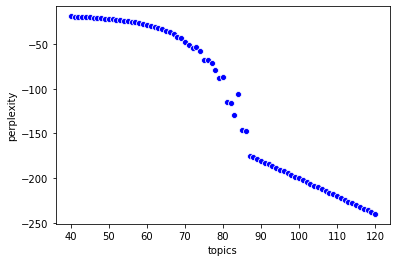

In [7]:
# plot the results - PERPLEXITY
sns.scatterplot(x="topics", y="perplexity", color="blue", data=results)

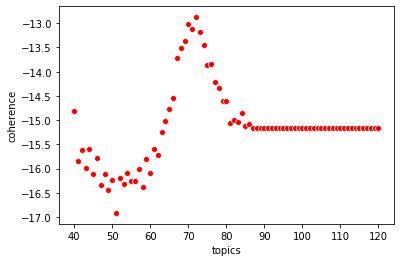

In [8]:
# plot the results - COHERENCE
sns.scatterplot(x="topics", y="coherence", color="red", data=results)

## 4. Create the "best" model using all data

And parameters decided by test-time performance on perplexity and coherence.

In [13]:
random.seed(42)

# Fit the final lda model to all data
lda_model_tfidf = LdaModel(corpus['corpus_tfidf'],
                           num_topics=70,
                           id2word=dictionary,
                           passes=2)

# Get the perplexity, out of curiosity
perplexity = lda_model_tfidf.log_perplexity(corpus['corpus_tfidf'])
    
# Get the coherence, out of curiosity
cm = CoherenceModel(model=lda_model_tfidf, corpus=corpus['corpus_tfidf'], coherence='u_mass')
coherence = cm.get_coherence()

print("perplexity = {}".format(perplexity), "coherence = {}".format(coherence))

#lda_model_tfidf.save("working/lda_model_tfidf.model")

perplexity = -50.095872303923876 coherence = -9.334707632149401


In [14]:
# Let's take a quick look at the topics picked out
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.146*"drug" + 0.082*"babi" + 0.069*"jail" + 0.067*"memori" + 0.063*"son" + 0.047*"keep" + 0.043*"mum" + 0.033*"ice" + 0.027*"old" + 0.027*"corps"
Topic: 1 Word: 0.139*"govern" + 0.127*"health" + 0.082*"plan" + 0.078*"aid" + 0.067*"lead" + 0.040*"track" + 0.035*"team" + 0.034*"ill" + 0.032*"problem" + 0.030*"forc"
Topic: 2 Word: 0.000*"deangelo" + 0.000*"againapo" + 0.000*"distribut" + 0.000*"pharmaci" + 0.000*"moder" + 0.000*"yellowston" + 0.000*"submit" + 0.000*"portion" + 0.000*"killerapo" + 0.000*"massag"
Topic: 3 Word: 0.138*"worker" + 0.085*"surg" + 0.073*"huge" + 0.072*"food" + 0.060*"reach" + 0.057*"current" + 0.057*"build" + 0.045*"nuclear" + 0.042*"ground" + 0.034*"blast"
Topic: 4 Word: 0.000*"deangelo" + 0.000*"againapo" + 0.000*"distribut" + 0.000*"pharmaci" + 0.000*"moder" + 0.000*"yellowston" + 0.000*"submit" + 0.000*"portion" + 0.000*"killerapo" + 0.000*"massag"
Topic: 5 Word: 0.124*"war" + 0.109*"europ" + 0.096*"busi" + 0.084*"troop" + 0.079*"german" + 0.

In [15]:
# Let's take a quick look at words the topics picked out
topic_word_dist = pd.DataFrame()

for idx, topic in lda_model_tfidf.print_topics(-1):
    
    # Record the topic index in a format R will like
    topic_index = "X" + str(idx)
    
    # Record the topic's key words as a single string
    # Split the words with a newline character while we're at it!
    topic_words = " ".join([x.split("*")[1].replace('"', '').strip() for x in topic.split("+")][0:5])
    
    # Dump them to the results dataframe
    topic_word_dist = topic_word_dist.append({"topic":topic_index, "keywords":topic_words}, ignore_index=True)
    
topic_word_dist

,keywords,topic
0,drug babi jail memori son,X0
1,govern health plan aid lead,X1
2,deangelo againapo distribut pharmaci moder,X2
3,worker surg huge food reach,X3
4,deangelo againapo distribut pharmaci moder,X4
...,...,...
65,deangelo againapo distribut pharmaci moder,X65
66,deangelo againapo distribut pharmaci moder,X66
67,imag histori best photograph wildlif,X67
68,protect concern treat lost battl,X68


In [16]:
# Assign topic to document, also store the probability of that topic
doc_topics = []

count = 0
for index, row in corpus.iterrows():
    
    # Extract list of tuples of (topic, score) from the model for each doc
    topics = [x for x in lda_model_tfidf.get_document_topics(row['corpus_tfidf']) ]
    
    # Find the highest probability topic
    highest_scoring = sorted(topics, key=lambda x: x[1], reverse=True)[0]
    
    temp = {"node": int(index),
            "cluster": highest_scoring[0],
            "score": highest_scoring[1]}
    
    # Report processing progress!
    count = count + 1
    if count % 10000 == 0:
        print(count)
    
    doc_topics.append(temp)

doc_topic_dist = pd.DataFrame(doc_topics).set_index("node")

corpus = corpus.join(doc_topic_dist)

# If cluster is smaller than minimum limit, designate as outlier
cs_lookup = corpus['cluster'].value_counts().to_dict()
corpus['cluster'] = corpus['cluster'].apply(lambda x: -1 if (cs_lookup[x] < 5) else x)

corpus.to_csv("working/RSS_clustered_lda.csv", index=False)

# What percentage are now classed as outliers?
print("Percent outlier: ", 100.0 * sum(corpus['cluster']==-1) / corpus.shape[0])

# How many unique clusters after all this?
print("Number of clusters: ", len(pd.unique(corpus['cluster'])))

10000
20000
30000
Percent outlier:  0.0
Number of clusters:  46


### Looking at the topic distribution, there's no obvious way to draw a line and cut off outliers

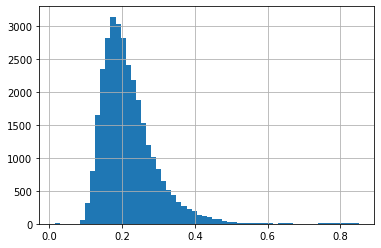

In [18]:
corpus['score'].hist(bins=60)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


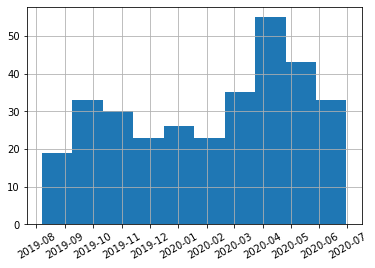

In [75]:
test = corpus[corpus['cluster']==3]
test['date'] = pd.to_datetime(test['date'].str.slice(5, 16))

test = test[test['date'].dt.year >= 2019]

test['date'].hist(xrot=30)

In [76]:
test.sample(5)[['title']].reset_index()

,node,title
0,17634,Gay &apos;conversion therapy&apos; may be bann...
1,3443,Boeing 'misjudged 737 Max pilot reactions'
2,6809,Migrating Russian eagles run up huge data roam...
3,21246,Coronavirus: How Italian cities have dealt wit...
4,13521,Tarragona explosion: One crushed to death in h...


c_v: 0.4927
c_npmi: 0.0111
Average document word count: 39.30283821234033
Number of documents: 31393
Latest record: Fri, 01 May 2020 00:18:25 GMT
Earliest record: Wed, 9 Oct 2019 21:52:38 +0000
Number of clusters: 47
Median cluster size: 564.0
Clustered docs: 100.0%

Best Performant (C_v)!
29622    UK Prime Minister Boris Johnson to Mark Grenfe...
17758    Warren scrambles to make up lost ground in Iow...
28611    George Floyd: Trump says something snapped in ...
3436     ISIS bride Shamima Begum begs to come back to ...
Name: clean_text, dtype: object
9578     Hong Kong protesters hope poll will send messa...
14749    Trump tells anti-abortion conservatives at Mar...
20889    Idiot TikTok user LICKS toilet seat in vile ‘c...
18646    Hes wearing a safety harness: Viewers dismiss ...
Name: clean_text, dtype: object
20923    We win: Trump appears to claim victory over co...
9516     Ethiopia's Abiy Ahmed gets a new ruling party....
9591     Community outrage as rural Brazilian schools g

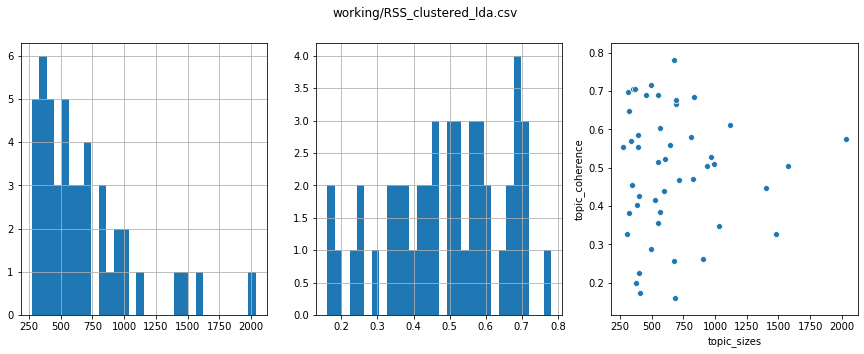

In [11]:
coherences = helper.report_corpus_model_coherence("working/RSS_clustered_lda.csv")